In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [2]:
BEG_TRAIN = '..' + os.sep + 'preprocess2' + os.sep + 'AgeGroups' + os.sep + '0' + os.sep
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep

dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])
dfLabels = pd.read_csv(BEG_TEST + 'gold_standard.csv')

def GetTestAge(i):
    return dfAgeSex.values[i][0]

testLabels = dfLabels.values
# deixar as labels na mesma ordem do treino
testLabels[:,4], testLabels[:,5] = testLabels[:,5], testLabels[:,4].copy()

def GetTargetAgeGroup(targetAge):
    targetAge = min(max(MIN_AGE, targetAge), MAX_AGE)
    targetAgeGroup = targetAge - MIN_AGE
    AGE_OFF = 5
    div = targetAgeGroup // AGE_OFF
    start = MIN_AGE + div * AGE_OFF
    end = start + AGE_OFF - 1
    targetAgeGroup = str(start) + '-' + str(end)
    return targetAgeGroup

def GetModel(targetAgeGroup):
    start = BEG_TRAIN + str(targetAgeGroup) + os.sep
    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    labels = np.load(start + 'labels.npy')
    tree = KDTree(ondas)
    return tree, ecgs, labels, mappings
    
def GetECGAndLabelsInNewAgeGroup(ecg, model):
    '''
    retorna o ECG mais próximo no espaço de features na nova idade,
    e as labels dele. Essa função faz tudo do 0 (lê os dados, constrói o modelo (KDTree)),
    então se o mesmo modelo for usado várias vezes, faz sentido parametrizar isso.
    '''
    
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')

    tree, ecgs, labels, mappings = model
        
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    ecgClosest = ecgs[ecgOrgRow]
    labelsEcgClosest = labels[ecgOrgRow]
    
    return ecgClosest, labelsEcgClosest

70 [0 0 1 0 0 0]


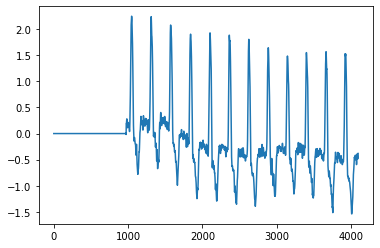

50 [0 0 1 0 0 0]


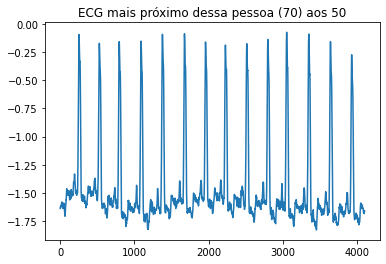

In [11]:
pessoa = 1
targetAge = 50

ecg = M[pessoa, :, ELETRODO_IDX]
age = GetTestAge(pessoa)
pessoaLabels = testLabels[pessoa]

targetAgeGroup = GetTargetAgeGroup(targetAge)
model = GetModel(targetAgeGroup)

print(age, pessoaLabels)
plt.plot(ecg)
plt.show()

plt.title('ECG mais próximo dessa pessoa (' + str(age) + ') aos ' + str(targetAge))
ecgClosest, labelsEcgClosest = GetECGAndLabelsInNewAgeGroup(ecg, model)
print(targetAge, labelsEcgClosest.astype(int))
plt.plot(ecgClosest)
plt.show()

In [4]:
targetAge = 40

In [5]:
targetAgeGroup = GetTargetAgeGroup(targetAge)
model = GetModel(targetAgeGroup)

In [6]:
N_TEST = len(M)
matched = []
for i in range(N_TEST):
    
    if i % 50 == 0:
        print(i, '/', N_TEST)
        
    ecg = M[i, :, ELETRODO_IDX]
    pessoaLabels = testLabels[i]
    
    def get():
        try:
            labelsEcgClosest = GetECGAndLabelsInNewAgeGroup(ecg, model)[1]
            return True
        except:
            print('Erro no ECG', i)
            return False
    if get():
        cmp = pessoaLabels == labelsEcgClosest
        matched.append(cmp)
    
matched = np.array(matched, dtype=int)

0 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
50 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
100 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
150 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
200 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
250 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
300 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit 

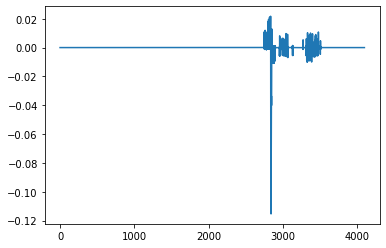

In [7]:
plt.plot(M[441,:,0])

In [8]:
# pessoas com algum 1 que tiveram match 100%
idx = []
for i in range(len(matched)):
    if testLabels[i].sum():
        if matched[i].sum() == 6:
            idx.append(i)
idx

[446,
 458,
 463,
 469,
 481,
 485,
 489,
 493,
 495,
 498,
 501,
 503,
 514,
 522,
 525,
 534,
 541,
 543,
 545,
 548,
 553,
 555,
 564,
 572,
 574,
 579,
 581,
 584,
 594,
 607,
 613,
 618,
 626,
 629,
 659,
 662,
 667,
 672,
 683,
 687,
 695,
 712,
 718,
 721,
 723,
 725,
 730,
 744,
 747,
 753,
 759,
 767,
 787,
 790]

In [9]:
matched

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1]])

In [10]:
(matched.sum(axis=1)==6).sum() # número de pessoas com as mesmas labels exatas

680